<font size = "5"> **Chapter 3: [Imaging](CH3_00-Imaging.ipynb)** </font>
<hr style="height:1px;border-top:4px solid #FF8200" />

# Image Processing

[Download](https://raw.githubusercontent.com/gduscher/MSE672-Introduction-to-TEM/main/Imaging/CH3_06-Image_Processing.ipynb)
 

[![OpenInColab](https://colab.research.google.com/assets/colab-badge.svg)](
    https://colab.research.google.com/github/gduscher/MSE672-Introduction-to-TEM/blob/main//Imaging/CH3_06-Image_Processing.ipynb)

part of 

<font size = "5"> **[MSE672:  Introduction to Transmission Electron Microscopy](../_MSE672_Intro_TEM.ipynb)**</font>


**Spring 2024**
<table style="margin-right:auto;margin-left:0px">
  <tr>
    <td>Gerd Duscher </td>
    <td>Khalid Hattar</td>
  </tr>
  <tr>
    <td>Microscopy Facilities</td> 
    <td> Tennessee Ion Beam Materials Laboratory </td>
  </tr>
  
  <tr>
    <td>Materials Science & Engineering</td>
    <td> Nuclear Engineering</td>
  </tr>
  <tr>
    <td>Institute of Advanced Materials & Manufacturing</td>
    <td> </td>
  </tr>
  <tr>
    <td colspan="2"><center> The University of Tennessee, Knoxville</center> </td>
  </tr>
</table>

Background and methods to analysis and quantification of data acquired with transmission electron microscopes.



## Load important packages

### Check Installed Packages

In [1]:
import sys
import importlib.metadata
def test_package(package_name):
    """Test if package exists and returns version or -1"""
    try:
        version = importlib.metadata.version(package_name)
    except importlib.metadata.PackageNotFoundError:
        version = '-1'
    return version

if test_package('pyTEMlib') < '0.2024.2.3':
    print('installing pyTEMlib')
    !{sys.executable} -m pip install  --upgrade pyTEMlib -q

print('done')

installing pyTEMlib
done


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
conda 24.3.0 requires setuptools>=60.0.0, but you have setuptools 58.2.0 which is incompatible.


### Import all relevant libraries

In [3]:
%matplotlib  widget
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
if 'google.colab' in sys.modules:
    from google.colab import output
    output.enable_custom_widget_manager()

# our blob detectors from the scipy image package
from skimage.feature import blob_dog, blob_log, blob_doh

# Multidimensional Image library
import scipy.ndimage as ndimage

import time
# Import libraries from pycrosccopy

import pyTEMlib
import pyTEMlib.file_tools          # File input/ output library
import pyTEMlib.kinematic_scattering as ks         # Kinematic sCattering Library

# it is a good idea to show the version numbers at this point for archiving reasons.
print('pyTEM version: ',pyTEMlib.__version__)

pyTEM version:  0.2024.02.2


### Load an atomic resolution image:
As an example we will use **p1-3-hr3.dm3** in the ``example_data`` directory.

The image is of a sample of ZnO grown on graphene.

In [4]:
# ---- Input ------
load_example = True
# -----------------
if not load_example:
    if 'google.colab' in sys.modules:
        drive.mount("/content/drive")
    fileWidget = file_tools.FileWidget()

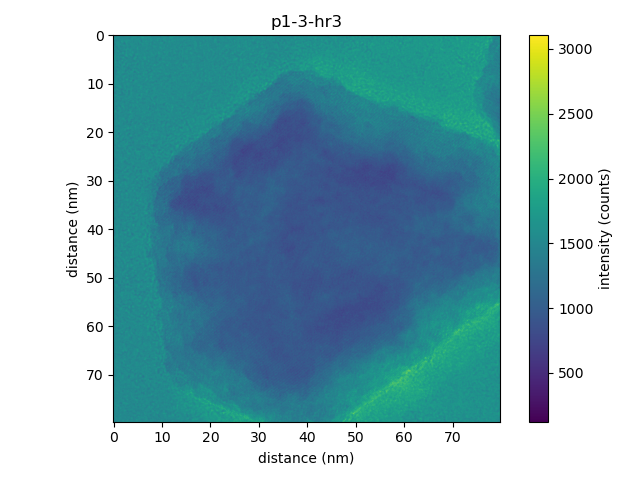

In [5]:
# ---- Input ------
load_example = True

file_name = 'p1-3-hr3.dm3'
# -----------------
      
if load_example:
    if 'google.colab' in sys.modules:
      if not os.path.exists('./'+file_name):
        !wget  https://github.com/gduscher/MSE672-Introduction-to-TEM/raw/main/example_data/p1-3-hr3.dm3
        !wget  https://github.com/gduscher/MSE672-Introduction-to-TEM/raw/main/example_data/p1-hr4-ZnOonGraphite.dm3
    else:
        datasets = pyTEMlib.file_tools.open_file('../example_data/'+file_name)
        dataset = datasets['Channel_000']
      
else:
    datasets = fileWidget.datasets
    dataset = fileWidget.selected_dataset
# Load file

view = dataset.plot()

## Fourier Transform of Image

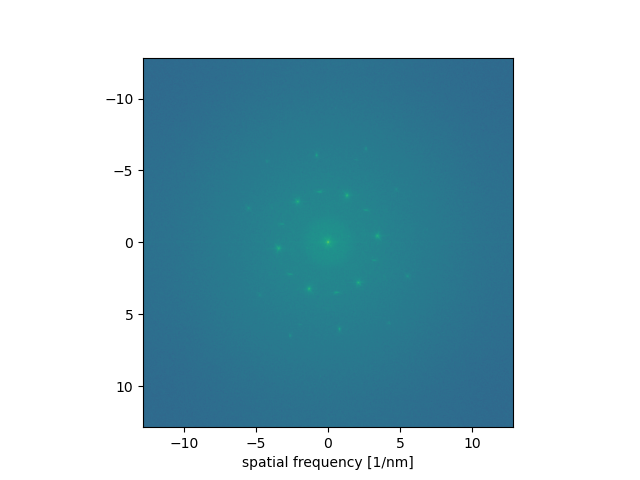

In [6]:

image = np.array(dataset-dataset.min())
fft_mag = np.abs((np.fft.fftshift(np.fft.fft2(image))))

## pixel_size in recipical space
rec_scale_x = 1/dataset.x[-1]  
rec_scale_y = 1/dataset.y[-1]

## Field of View (FOV) in recipical space please note: rec_FOV_x = 1/(scaleX*2)
rec_FOV_x = rec_scale_x * dataset.shape[0] /2.
rec_FOV_y = rec_scale_y * dataset.shape[1] /2.


## Field ofView (FOV) in recipical space
rec_extend = (-rec_FOV_x,rec_FOV_x,rec_FOV_y,-rec_FOV_y)

fig = plt.figure()
plt.imshow(np.log2(1+fft_mag).T, extent=rec_extend, origin = 'upper'); 
plt.xlabel('spatial frequency [1/nm]');


## Shorter

SimpleITK not installed; Registration Functions for Image Stacks not available
install with: conda install -c simpleitk simpleitk 


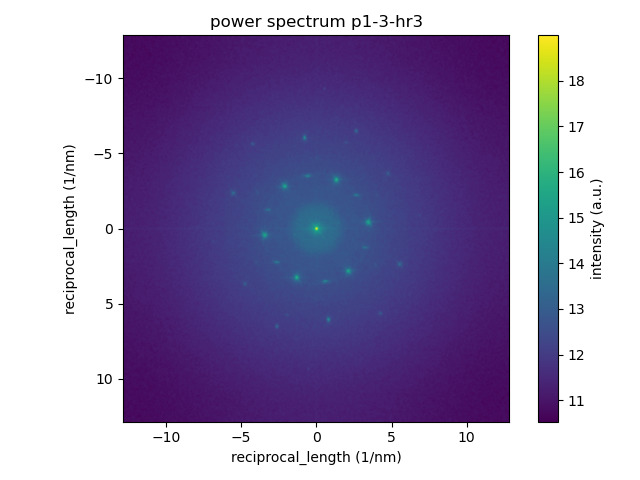

In [7]:
import sys
sys.path.insert(0, "../../pyTEMlib/")
from pyTEMlib import image_tools as it
fft_mag = it.power_spectrum(dataset)
view = fft_mag.plot()

## More Contrast in Fourier Transform

Part of the low contrast is the high frequency noise in the diffractogram.
Smoothing with a Gaussian (3pixels wide) increases the contrast on logarithmic intensity scale.

Additionally, the minimum and maximum intensity can be used to increase the plotted contrast. For that we want to exclude 
- the center spot, which does not carry any spatial information and 
- the high frequencies which have always low intensities. 


0.5914055959172136 11.579141679482428 18.256675689336674
3.340085191885885 4.176874317680241


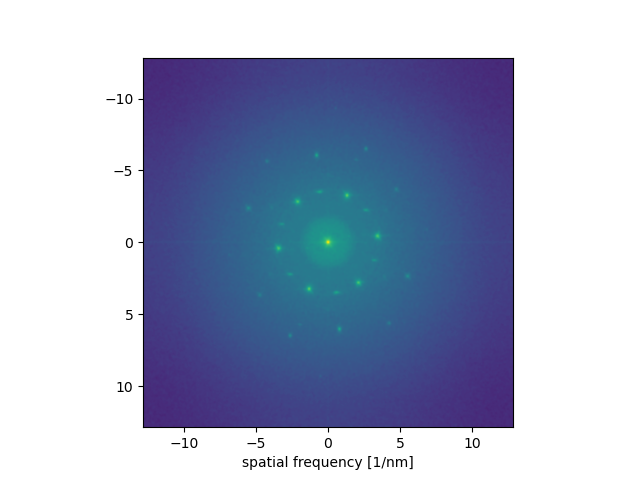

In [8]:
# We need some smoothing (here with a Gaussian)
smoothing = 3
fft_mag2 = ndimage.gaussian_filter(fft_mag, sigma=(smoothing, smoothing), order=0)


#prepare mask for low and high frequencies
pixels = (np.linspace(0,image.shape[0]-1,image.shape[0])-image.shape[0]/2)* rec_scale_x
x,y = np.meshgrid(pixels,pixels);
mask = np.zeros(image.shape)

mask_spot = x**2+y**2 > 2**2 
mask = mask + mask_spot
mask_spot = x**2+y**2 < 10**2 
mask = mask + mask_spot

mask[np.where(mask==1)]=0 # just in case of overlapping disks

fft_mag3 = fft_mag2*mask
print(np.std(fft_mag2),np.mean(fft_mag2) ,np.max(fft_mag2) )
#print(np.std(fft_mag2[np.where(mask==2)]),np.mean(fft_mag2[np.where(mask==2)]) ,np.max(fft_mag2[np.where(mask==2)]))


minimum_intensity = np.log2(.1+fft_mag2)[np.where(mask==2)].min()*0.95
#minimum_intensity = np.mean(fft_mag3)-np.std(fft_mag3)
maximum_intensity = np.log2(.1+fft_mag2)[np.where(mask==2)].max()*1.05
#maximum_intensity =  np.mean(fft_mag3)+np.std(fft_mag3)*2

print(minimum_intensity,maximum_intensity)
fig2 = plt.figure()
plt.imshow(np.log2(.1+fft_mag2).T, extent=rec_extend, origin = 'upper',vmin=minimum_intensity, vmax=maximum_intensity)
plt.xlabel('spatial frequency [1/nm]');


## Spot Detection

This diffractogram is now good enough to detect the spots with a blob detector.

Found 23 reflections


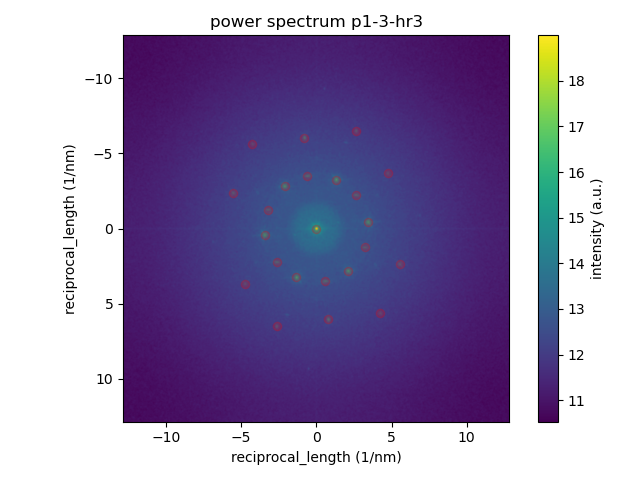

In [9]:
# ---- Input ---------
spot_threshold = .4
# --------------------

## Needed for conversion from pixel to Reciprocal space
rec_scale = np.array([rec_scale_x, rec_scale_y,1])
center = np.array([int(image.shape[0]/2), int(image.shape[1]/2),1] )

fft_mag2 = ndimage.gaussian_filter(fft_mag, sigma=(smoothing, smoothing), order=0)
fft_mag2 = fft_mag2-fft_mag2.min()
#fft_mag2 = fft_mag2/fft_mag2.max()

# spot detection ( for future reference there is no symmetry assumed here)

spots_random =  (blob_log(fft_mag,  max_sigma= 5 , threshold=spot_threshold)-center)*rec_scale

print(f'Found {spots_random.shape[0]} reflections')
spots_random[:,2] = np.linalg.norm(spots_random[:,0:2], axis=1)
spots_index = np.argsort(spots_random[:,2])
spots = spots_random[spots_index]

## plot Fourier transform and found spots
view2 = fft_mag.plot()
plt.gca().scatter(spots[:,0], spots[:,1], c='Red',  alpha = 0.2, label='spots');
#plt.xlim(-0.2,0.2)
#plt.ylim(-0.2,0.2);

## Adaptive Fourier Filtering

We mask the fourier transformed image so that the information can pass through is selected.

The information is in the spots and in the center of the Fourier transformed image, the rest is noise.

Please modify the radius of the mask of the **reflections** and the **low-pass** area in the code below and notice the effects on the Fourier filtered image.



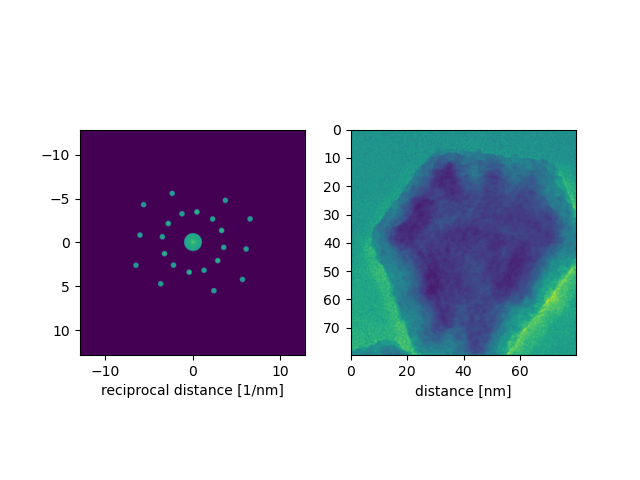

In [10]:
# Input 
reflection_radius = 0.3 # in 1/nm
low_pass = 1/0.99534 # in 1/nm diameter of mask for low pass filter
FOV_x = dataset.x[-1]
FOV_y = dataset.y[-1]


#prepare mask
pixels = (np.linspace(0,image.shape[0]-1,image.shape[0])-image.shape[0]/2)* rec_scale_x

x,y = np.meshgrid(pixels,pixels);
mask = np.zeros(image.shape)

# mask reflections
for spot in spots:
    mask_spot = (x-spot[0])**2+(y-spot[1])**2 < reflection_radius**2 # make a spot 
    mask = mask + mask_spot# add spot to mask
    
# mask zero region larger (low-pass filter = intensity variations)

mask_spot = x**2+y**2 < low_pass**2 
mask = mask + mask_spot

mask[np.where(mask>1)]=1 # just in case of overlapping disks

plt.figure()
ax1 = plt.subplot(1,2,1)
#ax1.imshow(mask)
fft_filtered = np.fft.fftshift(np.fft.fft2(image))*mask.T
ax1.imshow(np.log(1+np.abs(fft_filtered)).real,extent=rec_extend, origin = 'upper')
plt.xlabel('reciprocal distance [1/nm]')
ax2 = plt.subplot(1,2,2)
filtered = np.fft.ifft2(np.fft.fftshift(fft_filtered))

real_extent = (0,FOV_x,FOV_y,0)
    
ax2.imshow(filtered.real,extent=real_extent, origin = 'upper')
plt.xlabel('distance [nm]');


### Plot the image a bit bigger

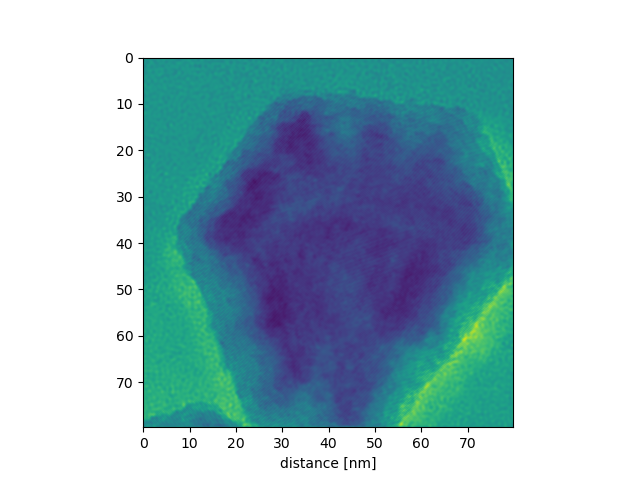

In [11]:
plt.figure()
plt.imshow(filtered.real, extent=real_extent, origin = 'upper')
plt.xlabel('distance [nm]');

## Check on filtered images

We don't want to filter anything out that caries information, or at least we want to be aware of that. 
An easy check is to subtract the filtered imag fromt he image and to determine that only noise is left.

Please note that any processing can be easily determined in the Fourier transformed, so be meticulous on reporting what you did to an image.


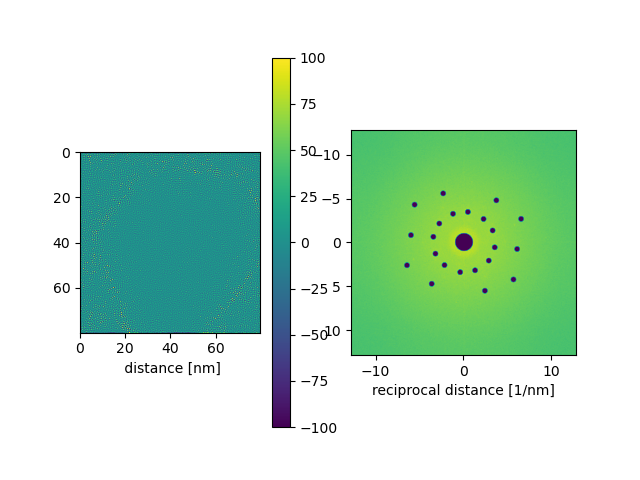

In [12]:
filtered = np.array(filtered)
plt.figure()
ax1 = plt.subplot(1,2,1)
im1 = ax1.imshow(image-filtered.real,extent=real_extent, origin = 'upper', vmin=-100, vmax=100)
plt.xlabel(' distance [nm]')
plt.colorbar(im1)
ax2 = plt.subplot(1,2,2)
fft_difference = np.fft.fftshift(np.fft.fft2(image-filtered.real).T)
im2 = ax2.imshow(np.log(1+np.abs(fft_difference)).real.T,extent=rec_extend, origin = 'upper')
plt.xlabel('reciprocal distance [1/nm]');

## Conclusion:

Fourier Transform is used to evaluate image quality and Fourier Filtering is used to eliminate high frequency noise.

If the computer is used to find the spots in the diffractogram, we do not have to select them ourselfs.
A carefull selection will,however, yield the same result.

## Navigation
- <font size = "3">  **Up Chapter 3: [Imaging](CH3_00-Imaging.ipynb)** </font>
- <font size = "3">  **Back: [Defocus Thickness Map](CH3_05-Defocus_Thickness.ipynb)** </font>
- <font size = "3">  **Next: [Image Analysis](CH3_07-Image_Analysis.ipynb)** </font>
- <font size = "3">  **List of Content: [Front](../_MSE672_Intro_TEM.ipynb)** </font>
